In [108]:
import numpy as np
import pandas as pd
from data_processing import process_data
from graph import HandOnlyGraph
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import random_split, DataLoader
from collections import Counter
from torch.utils.data import WeightedRandomSampler

In [ ]:
import numpy as np

def jitter(x, sigma=0.03):
    noise = np.random.normal(0, sigma, size=x.shape)
    return x + noise

def drop_random_frames(x, drop_ratio=0.1):
    T = x.shape[1]
    keep = np.sort(np.random.choice(T, int(T * (1 - drop_ratio)), replace=False))
    x_dropped = x[:, keep, :]  # correct for 3D [C, T, V]

    # Pad back to original length
    padded = np.zeros_like(x)
    padded[:, :x_dropped.shape[1], :] = x_dropped
    return padded



In [110]:
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, augment=True):
        self.x = x
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx].copy()  # avoid changing original
        y = self.y[idx]
        if self.augment:
            if np.random.rand() < 0.5:
                x = jitter(x)
            if np.random.rand() < 0.5:
                x = drop_random_frames(x)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


In [ ]:
# get data ready
x_train = np.load(r'C:\Users\19692\Downloads\UB-CSE-555\st-gcn\final_dataset\videos_300_train.npy')
x_val = np.load(r'C:\Users\19692\Downloads\UB-CSE-555\st-gcn\final_dataset\videos_300_val.npy')
x_test = np.load(r'C:\Users\19692\Downloads\UB-CSE-555\st-gcn\final_dataset\videos_300_test.npy')


x_train = x_train.squeeze(-1).astype(np.float32)  # cut the last dimension which is 1
x_val = x_val.squeeze(-1).astype(np.float32)
x_test = x_test.squeeze(-1).astype(np.float32)

df_train = pd.read_csv(r'C:\Users\19692\Downloads\UB-CSE-555\st-gcn\final_dataset\labels_300_train.csv')
df_val = pd.read_csv(r'C:\Users\19692\Downloads\UB-CSE-555\st-gcn\final_dataset\labels_300_val.csv')
df_test = pd.read_csv(r'C:\Users\19692\Downloads\UB-CSE-555\st-gcn\final_dataset\labels_300_test.csv')




label_encoder = LabelEncoder()
all_labels = np.concatenate([df_train["label"], df_val["label"], df_test["label"]])
label_encoder.fit(all_labels)

y_train = label_encoder.transform(df_train["label"]).astype(np.int64)
y_val   = label_encoder.transform(df_val["label"]).astype(np.int64)
y_test  = label_encoder.transform(df_test["label"]).astype(np.int64)



# filter the top 50 words with most videoes
df_all = pd.concat([df_train, df_val, df_test])
top_labels = df_all["label"].value_counts().head(50).index

# Filter train/val/test sets
def filter_top(x_data, y_data, top_labels):
    mask = np.isin(label_encoder.inverse_transform(y_data), top_labels)
    return x_data[mask], y_data[mask]

x_train, y_train = filter_top(x_train, y_train, top_labels)
x_val, y_val = filter_top(x_val, y_val, top_labels)
x_test, y_test = filter_top(x_test, y_test, top_labels)


from torch.utils.data import TensorDataset, DataLoader

train_dataset = AugmentedDataset(x_train, y_train, augment=True)
val_dataset   = AugmentedDataset(x_val, y_val, augment=False)
test_dataset = AugmentedDataset(x_test, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



In [120]:
x_train.shape

(786, 2, 64, 42)

In [121]:
graph = HandOnlyGraph()
adjacency_matrix = graph.get_adjacency_matrix()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [122]:
class STGCNBlock(nn.Module):
    def __init__(self, in_channel, out_channel, A, stride = 1, residual = True):
        
        super().__init__()
        self.register_buffer("A", torch.tensor(A, dtype=torch.float32))
        self.gcn = nn.Conv2d(in_channel, out_channel, kernel_size=(1,1))
        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=(9, 1), 
                      stride=(stride,1), padding=(4,0)),
            nn.BatchNorm2d(out_channel)
        )
        

        if not residual:
            self.residual =None
        elif in_channel == out_channel and stride == 1:
            self.residual = nn.Identity() 
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=(stride,1)),
                nn.BatchNorm2d(out_channel)
            )

        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        A = self.A.to(x.device, non_blocking=True) 
        x_gcn = self.gcn(x)
        x_gcn = torch.einsum('nctv,kvw->nctw', x_gcn, A)

        res = 0 if self.residual is None else self.residual(x)
        x_tcn = self.tcn(x_gcn) + res

        return self.relu(x_tcn)


In [123]:
class STGCN(nn.Module):
    def __init__(self, A, num_classes):
        super().__init__()
        self.data_bn = nn.BatchNorm1d(42 * 2)  # 42 joints × 2 channels 
        self.layer1 = STGCNBlock(2, 32, A, residual=False)
        self.layer2 = STGCNBlock(32, 64, A)
        self.layer3 = STGCNBlock(64, 128, A)
        self.layer4 = STGCNBlock(128, 256, A)


        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        n, c, t, v = x.shape
        x = x.permute(0, 3, 1, 2).contiguous().view(n, v * c, t)
        x = self.data_bn(x)
        x = x.view(n, v, c, t).permute(0, 2, 3, 1).contiguous()

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [124]:

model = STGCN(adjacency_matrix, num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # improve try 1
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

In [125]:
train_acc_list = []
val_acc_list = []


In [126]:
num_epochs = 10000
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    # -------- Train --------
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).long()

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()
        train_total += batch_y.size(0)

    train_acc = train_correct / train_total
    avg_loss = train_loss / len(train_loader)

    # -------- Validate --------
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(device), val_y.to(device).long()
            outputs = model(val_x)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == val_y).sum().item()
            val_total += val_y.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch {epoch:03d} | Train Acc: {train_acc:.2%} | Val Acc: {val_acc:.2%} | Loss: {avg_loss:.4f}")

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    # -------- Save Best Model --------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f">>> Saved new best model with Val Acc: {val_acc:.2%}")

Epoch 001 | Train Acc: 8.40% | Val Acc: 6.04% | Loss: 5.0291
>>> Saved new best model with Val Acc: 6.04%
Epoch 002 | Train Acc: 13.87% | Val Acc: 7.14% | Loss: 4.1010
>>> Saved new best model with Val Acc: 7.14%
Epoch 003 | Train Acc: 15.65% | Val Acc: 12.64% | Loss: 3.8584
>>> Saved new best model with Val Acc: 12.64%
Epoch 004 | Train Acc: 19.85% | Val Acc: 13.74% | Loss: 3.6905
>>> Saved new best model with Val Acc: 13.74%
Epoch 005 | Train Acc: 19.72% | Val Acc: 13.19% | Loss: 3.5935
Epoch 006 | Train Acc: 22.77% | Val Acc: 14.29% | Loss: 3.5566
>>> Saved new best model with Val Acc: 14.29%
Epoch 007 | Train Acc: 25.06% | Val Acc: 12.64% | Loss: 3.5098
Epoch 008 | Train Acc: 26.97% | Val Acc: 16.48% | Loss: 3.3865
>>> Saved new best model with Val Acc: 16.48%
Epoch 009 | Train Acc: 27.23% | Val Acc: 15.93% | Loss: 3.3850
Epoch 010 | Train Acc: 29.64% | Val Acc: 13.19% | Loss: 3.2801
Epoch 011 | Train Acc: 31.17% | Val Acc: 16.48% | Loss: 3.2178
Epoch 012 | Train Acc: 32.57% | Val 

KeyboardInterrupt: 

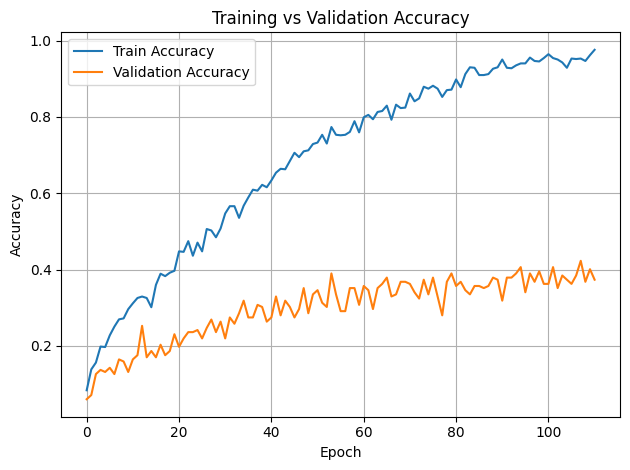

In [129]:
import matplotlib.pyplot as plt

actual_epoch = [i for i in range(len(train_acc_list))]

epochs = range(1, num_epochs + 1)
plt.plot(actual_epoch, train_acc_list, label='Train Accuracy')
plt.plot(actual_epoch, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [130]:
# -------- Final Test (optional) --------
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device).long()
        preds = model(x_test).argmax(1)
        test_correct += (preds == y_test).sum().item()
        test_total += y_test.size(0)

test_acc = test_correct / test_total
print(f"\n>>> Final Test Accuracy (best model): {test_acc:.2%}")

C:\Users\19692\AppData\Local\Temp\ipykernel_40204\1653716947.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))



>>> Final Test Accuracy (best model): 43.66%
